In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [8]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from astropy.io import ascii
import matplotlib.pyplot as plt

from dr25 import dr25

In [436]:
session = tf.InteractiveSession()

durations = np.array([1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 6.0, 7.5, 9.0, 10.5, 12.0, 12.5, 15.0])
cdpp_cols = ["rrmscdpp01p5", "rrmscdpp02p0", "rrmscdpp02p5", "rrmscdpp03p0",
             "rrmscdpp03p5", "rrmscdpp04p5", "rrmscdpp05p0", "rrmscdpp06p0",
             "rrmscdpp07p5", "rrmscdpp09p0", "rrmscdpp10p5", "rrmscdpp12p0",
             "rrmscdpp12p5", "rrmscdpp15p0"]

stlr_cols = cdpp_cols + ["kepid", "rad", "teff", "logg", "dataspan", "dutycycle", "gamma1", "gamma2"]

min_prad = 0.7
max_prad = 15
min_period = 1.0
max_period = 100.0

In [437]:
experiment_name = "sunlike_short_period"
dirname = os.path.join("experiments", experiment_name)

with open(os.path.join(dirname, "params.json"), "r") as f:
    params = json.load(f)
# max_period = params["max_period"]
    
with open(os.path.join(dirname, "robo.json"), "r") as f:
    robo = json.load(f)
    
with open(os.path.join(dirname, "pdet_model.json"), "r") as f:
    pdet_model = json.load(f)
    
stlr = pd.read_csv(os.path.join(dirname, "stlr.csv"))

In [438]:
kois = ascii.read("data/q1_q17_dr25_koi.txt").to_pandas()
kois = pd.merge(kois, stlr[stlr_cols], on="kepid")

prad = kois.koi_ror * kois.rad / 0.009158

m = kois.koi_pdisposition == "CANDIDATE"
m &= kois.koi_period < max_period
m &= kois.koi_period > min_period
m &= prad < max_prad
m &= prad > min_prad

kois["prad"] = prad

kois = pd.DataFrame(kois[m])
print("selected {0} KOIs".format(len(kois)))

selected 1656 KOIs


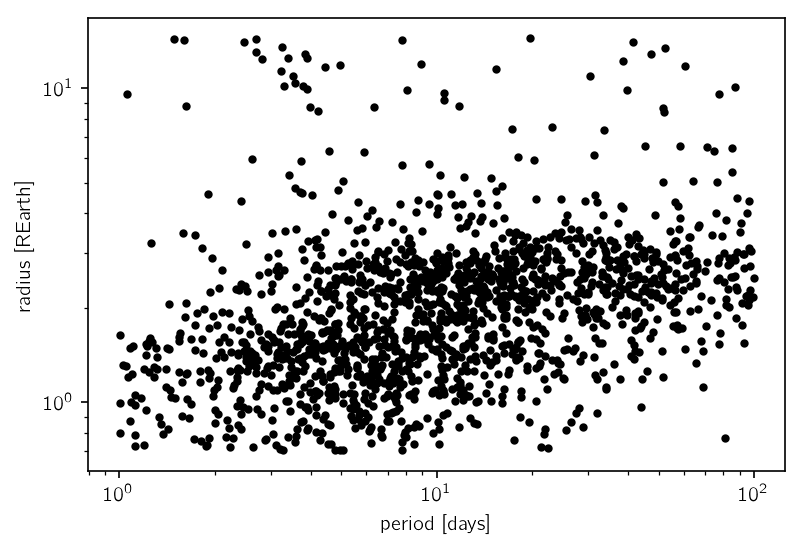

In [439]:
plt.loglog(kois.koi_period, kois.prad, ".k")
plt.xlabel("period [days]")
plt.ylabel("radius [REarth]");

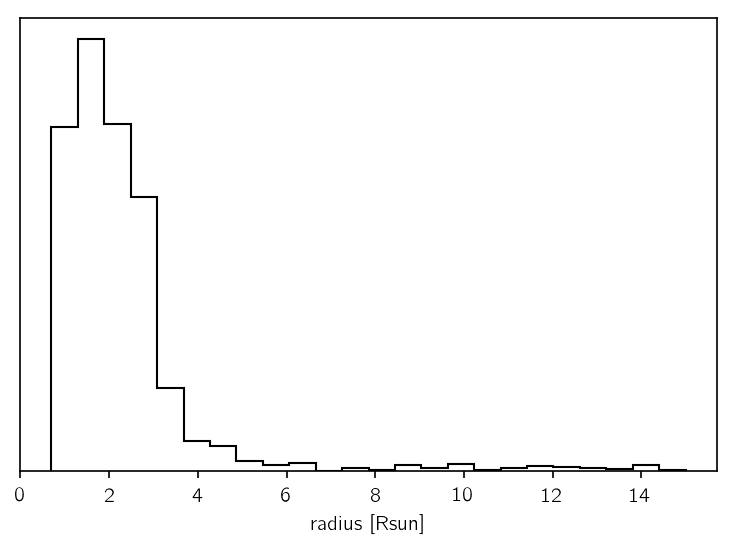

In [440]:
bins = np.linspace(min_prad, max_prad, 25)
plt.hist(kois.prad, bins, color="k", histtype="step")
plt.gca().set_yticks([])
plt.xlabel("radius [Rsun]");

In [441]:
T = tf.float64

R_star = tf.placeholder(T, (None,), name="R_star")
logg_star = tf.placeholder(T, (None,), name="logg_star")
gamma_star = tf.placeholder(T, (None, 2), name="gamma_star")
cdpp_star = tf.placeholder(T, (None, len(durations)), name="cdpp_star")
dataspan_star = tf.placeholder(T, (None,), name="dataspan_star")
dutycycle_star = tf.placeholder(T, (None,), name="dutycycle_star")
R_pl = tf.placeholder(T, (None,), name="R_pl")
P_pl = tf.placeholder(T, (None,), name="P_pl")
b_pl = tf.placeholder(T, (None,), name="b_pl")

# Completeness model
comp_norm = tf.Variable(pdet_model["comp_norm"], dtype=T, name="comp_norm")
mes0_p = tf.Variable(pdet_model["mes0"], dtype=T, name="mes0")
log_sig_mes_p = tf.Variable(pdet_model["log_sigma_mes"], dtype=T, name="log_sig_mes")

# Estimate the transit properties
ror_pl = 0.009158 * R_pl / R_star
M_star = 10.0**(logg_star-4.437) * tf.square(R_star)
a_pl = 215.0 * M_star**(1.0/3.0) * (P_pl/365.25)**(2.0/3.0)
a_pl = tf.clip_by_value(a_pl, R_star, a_pl)
arg = tf.square(a_pl) - tf.square(R_star * b_pl)
a_pl_sin_i = tf.sqrt(tf.clip_by_value(arg, tf.zeros_like(arg), arg))
arg = (1.0+ror_pl)**2-b_pl**2
arg = tf.clip_by_value(arg, tf.zeros_like(arg), arg)
arg = R_star * tf.sqrt(arg) / a_pl_sin_i
arg = tf.clip_by_value(arg, -1.0+1e-5, 1.0-1e-5)
tau_tot = P_pl * tf.asin(arg) / np.pi
arg = (1.0-ror_pl)**2-b_pl**2
arg = tf.clip_by_value(arg, tf.zeros_like(arg), arg)
arg = R_star * tf.sqrt(arg) / a_pl_sin_i
arg = tf.clip_by_value(arg, -1.0+1e-5, 1.0-1e-5)
tau_full = P_pl * tf.asin(arg) / np.pi
shape_pl = tau_full / tau_tot
tau_pl = 0.5 * (tau_tot + tau_full)

depth = (1.0 - dr25.quad(gamma_star[:, 0], gamma_star[:, 1], ror_pl, b_pl)) * 1e6

# The completeness model should be a function of shape
x = shape_pl
x2 = tf.square(x)
mes0 = mes0_p[0] + mes0_p[1] * x + mes0_p[2] * x2
log_sig_mes = log_sig_mes_p[0] + log_sig_mes_p[1] * x + log_sig_mes_p[2] * x2

# Interpolate the CDPP grid
cdpp = dr25.interp(tau_full, durations, cdpp_star)

# Estimate the MES
ntran = dataspan_star * dutycycle_star / P_pl
mes = tf.sqrt(ntran) * depth / cdpp

# Completeness as a function of MES
pdet = comp_norm / (1.0 + tf.exp(-(tf.log(mes) - tf.log(mes0)) * tf.exp(-log_sig_mes)))
pdet = tf.clip_by_value(pdet, 0.0, 1.0)

# Compute the window function
M = dataspan_star / P_pl
f = dutycycle_star
omf = 1.0 - f
pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
msk = tf.logical_and(pw >= 0.0, M >= 2.0)
pwin = tf.where(msk, pw, tf.zeros_like(pw))

# And the geometric transit prob
pgeom = R_star / a_pl
pgeom = tf.clip_by_value(pgeom, 0.0, 1.0)
# 1. / (aor * (1 - e*e)) * (aor > 1.0)

pdet_tot = pdet * pwin * pgeom * robo["eff"]

session.run(tf.global_variables_initializer())

In [442]:
Nint = 1000000
np.random.seed(42)
inds = np.random.randint(len(stlr), size=Nint)
rp = np.exp(np.random.uniform(np.log(min_prad), np.log(max_prad), Nint))
period = np.exp(np.random.uniform(np.log(min_period), np.log(max_period), Nint))

feed = {
    R_star: np.array(stlr.rad)[inds],
    logg_star: np.array(stlr.logg)[inds],
    gamma_star: np.array(stlr[["gamma1", "gamma2"]])[inds],
    cdpp_star: np.array(stlr[cdpp_cols])[inds],
    dataspan_star: np.array(stlr.dataspan)[inds],
    dutycycle_star: np.array(stlr.dutycycle)[inds],
    R_pl: rp,
    P_pl: period,
    b_pl: np.random.rand(Nint),
}

Q = session.run(pdet_tot, feed_dict=feed)

In [443]:
# plt.scatter(period, rp, c=Q, s=3, edgecolor="none", vmin=0.0, vmax=0.1)
# plt.colorbar()
# plt.xscale("log")
# plt.yscale("log");

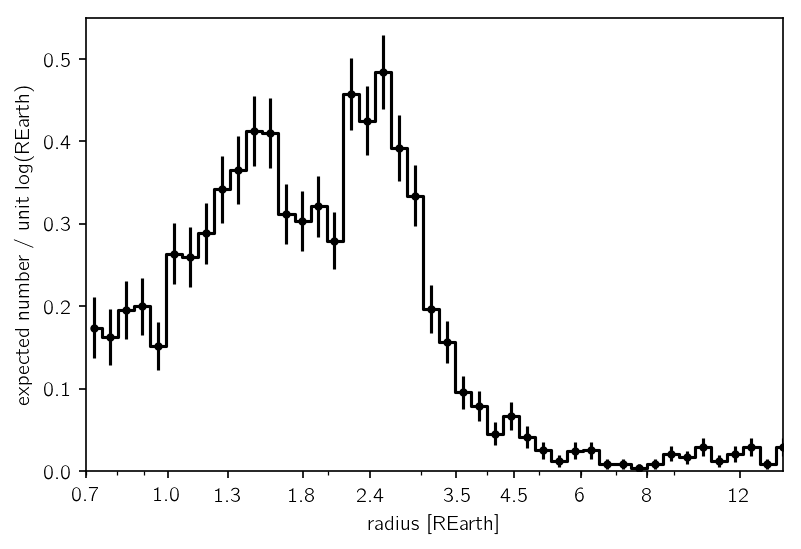

In [464]:
bins = np.linspace(np.log(min_prad), np.log(max_prad), 45)
num, _ = np.histogram(np.log(rp), bins, weights=Q)
denom, _ = np.histogram(np.log(rp), bins)
n_det, _ = np.histogram(np.log(kois.prad), bins)

area = (bins[1] - bins[0])
occ = n_det * denom / (num * area) / len(stlr)
err = occ / np.sqrt(n_det)

x = 0.5*(bins[1:] + bins[:-1])
plt.errorbar(np.exp(x), occ, yerr=err, fmt=".", color="k")
plt.step(np.exp(x), occ, where="mid", color="k")
plt.xscale("log")
plt.xlim(np.exp(x[0]), np.exp(x[-1]))
plt.ylim(0, 0.55)
plt.ylabel("expected number / unit log(REarth)")
plt.xlabel("radius [REarth]")
plt.xticks([0.7, 1.0, 1.3, 1.8, 2.4, 3.5, 4.5, 6.0, 8.0, 12.0],
           ["0.7", "1.0", "1.3", "1.8", "2.4", "3.5", "4.5", "6", "8", "12"]);

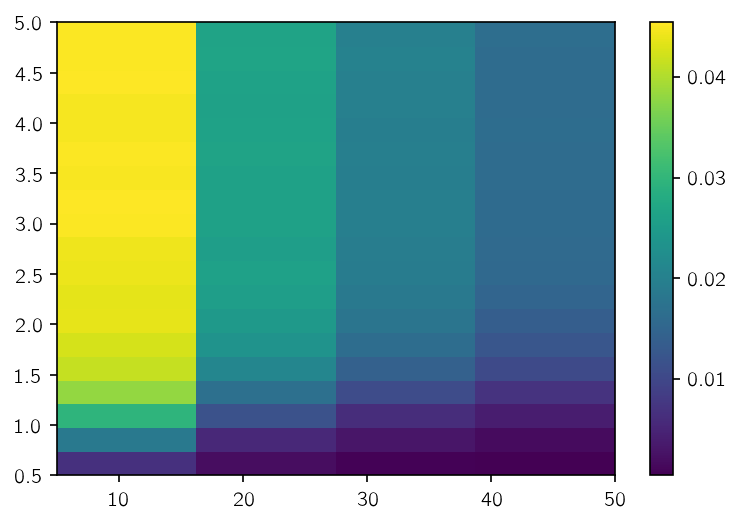

In [286]:
bins = (
    np.linspace(min_period, max_period, 5),
    np.linspace(min_prad, max_prad, 20),
)

num, _, _ = np.histogram2d(period, rp, bins, weights=Q)
denom, _, _ = np.histogram2d(period, rp, bins)

plt.pcolor(*bins, (num/denom).T)
plt.colorbar()

In [254]:
n_det, _, _ = np.histogram2d(kois.koi_period, kois.koi_ror * kois.rad, bins)
n_det /= len(stlr)

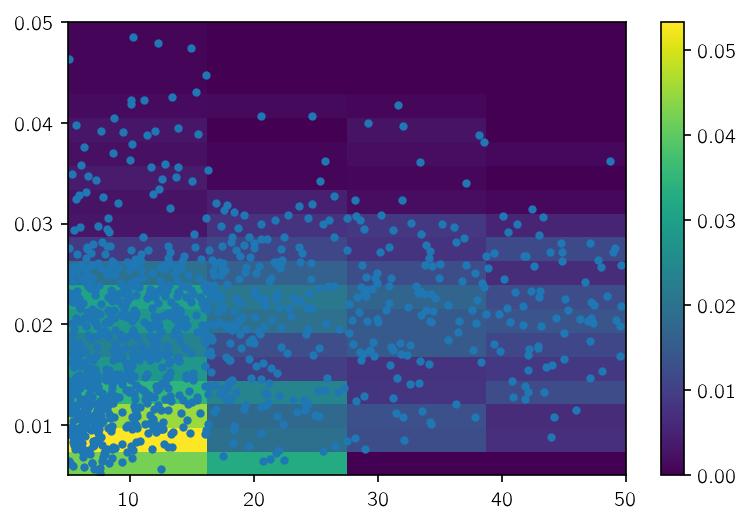

In [255]:
occ = denom * n_det / num
occ_ivar = np.zeros_like(occ)
m = occ > 0
occ_ivar[m] = n_det[m] / occ[m]**2
plt.pcolor(*bins, occ.T)
plt.plot(kois.koi_period, kois.koi_ror * kois.rad, ".")
plt.colorbar()

In [256]:
marg_var = 1.0 / np.sum(occ_ivar, axis=0)
marg_occ = marg_var * np.sum(occ_ivar * occ, axis=0)

<ErrorbarContainer object of 3 artists>

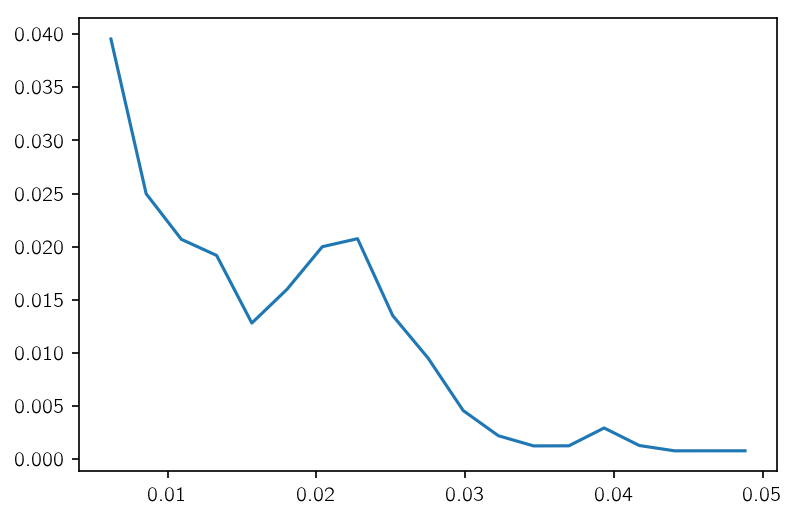

In [257]:
x = 0.5*(bins[1][:-1] + bins[1][1:])
plt.errorbar(x, marg_occ)